# PDF Image Extraction Experimental notebook

---
Author: Phillipe Cardenuto ( RECOD - UNICAMP)

email: phillipe.cardenuto@ic.unicamp.br

---

## Instructions

Before running this notebook make sure to build the pdf-content-extraction docker
```
     $ cd docker && ./build.sh
```


During the experimental setup all PDF files from the dataset will be copy to a temporary
folder, named as `pdfs`, and all files will be renamed according to the PDF-KEY in the
`pdf-image-experimental-setup.json`.

Inside the JSON file, you will find the following structure:
```
PDF-KEY: {
  'pdf-path': 'pdfs/<PDF-KEY>.pdf',
  'figures-pdf-location': {
      'fig1': {
         'figure-path': 'figures/<PDF-KEY>/fig1.<ext>',
         'figure-url' :'<link-to-original-available-figure>,
         'caption-path': 'caption/<PDF-KEY>/fig1.<ext>',
         'caption-txt': <caption-text>,
         'bbox_loc': {'p': <int>, 'x0': <int>, 'x1': <int>, 'y0': <int>, 'y1': <int>}
      }                  
  }
}
```

Warning:
-------

This notebook uses the script `run_image_extraction.sh` to extract the image from a PDF file


Make sure to have this file in the same directory of this notebook


This Notebook was updated on 4/15/2024 with new results after using scikit-image==0.23.1

# Requirements

You shouldn't have any issue after install the following
packages with pip
```
tqdm
scikit-image>=0.16
opencv-python>=3
imagecodecs  <-- deal with tiff images
```

# Code

In [1]:
# Import Library
from glob import glob
import shutil
import json
import subprocess
import os, pathlib
import imghdr
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map


<mark> Make sure to install the docker pdf-content-extraction</mark>.

**For this, just run the next cell**

In [2]:
%%bash
cd docker && ./build.sh

#1 [internal] load .dockerignore
#1 transferring context: 2B done
#1 DONE 0.0s

#2 [internal] load build definition from Dockerfile
#2 transferring dockerfile: 1.25kB done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/ubuntu:18.04
#3 DONE 0.4s

#4 [ 1/15] FROM docker.io/library/ubuntu:18.04@sha256:152dc042452c496007f07ca9127571cb9c29697f42acbfad72324b2bb2e43c98
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 1.88kB done
#5 DONE 0.0s

#6 [11/15] RUN pip3 install -r requirements.txt
#6 CACHED

#7 [ 2/15] RUN apt-get update && apt-get install -y     python3.6-dev     python3-pip    poppler-utils     libsm6     libxext6     libxrender-dev     tesseract-ocr     libgl1-mesa-glx     && rm -rf /var/lib/apt/lists/*
#7 CACHED

#8 [ 8/15] WORKDIR /work/PDF-Image-Extraction
#8 CACHED

#9 [ 9/15] RUN pip3 install -r requirements.txt
#9 CACHED

#10 [ 6/15] COPY facade facade
#10 CACHED

#11 [13/15] WORKDIR /work
#11 CACHED

#12 [ 4/15] COPY PDF-Image-Extract

In [3]:
def extract_image(pdf_file, output_path='.'):
    cmd = f'./run_image_extraction.sh {pdf_file} {output_path}'
    result = subprocess.run(cmd,shell=True,stdout=subprocess.PIPE)
    return result.stdout.decode('utf-8')


## Testing the extraction for samples file

In [4]:
# Creates the folder test
os.makedirs('pdf-img-extraction-test/',exist_ok=True)
# Run simple tests
sample_1 = extract_image('sample_1.pdf','pdf-img-extraction-test/')
print(sample_1)
sample_2 = extract_image('sample_2.pdf','pdf-img-extraction-test/')
print(sample_2)

sample_1.pdf
/INPUT/sample_1.pdf
Extraction Done!

sample_2.pdf
/INPUT/sample_2.pdf
Extraction Done!



# Experiment setup

The following experimental setup uses licensed data. 

You can download these data by downloading each PDF and Figure from the [pdf-content-extraction-data/pdf-content-extraction-annotation.json](https://github.com/danielmoreira/sciint/blob/pdf-content-extraction/pdf-content-extraction-data/pdf-content-extraction-annotation.json)
or by contacting [Prof. Daniel Moreira](https://github.com/danielmoreira/sciint/blob/provenance-analysis/daniel.moreira@nd.edu) to have access to the password for the file [pdf-content-extraction-data.zip](https://github.com/danielmoreira/sciint/blob/pdf-content-extraction/pdf-content-extraction-data/pdf-content-extraction-data.zip)

After unzip the pdf-content-extraction-data.zip or downloading each of the files in [pdf-content-extraction-annotation.json](https://github.com/danielmoreira/sciint/blob/pdf-content-extraction/pdf-content-extraction-data/pdf-content-extraction-annotation.json), you should have the following structure:
```
pdf-content-extraction-data/
├── captions
├── figures
├── pdf-content-extraction-annotation.json
├── pdf-content-extraction-data.zip
└── pdfs
```

In [5]:
# read annotations
with open('pdf-content-extraction-data/pdf-content-extraction-annotation.json') as file:
    annotations = json.load(file)

# Run Method

In [6]:
# after setting up the experiemntal environment, now we will run the method

# first, creat a list with all pdfs paths
base_path = 'pdf-content-extraction-data/'
pdfs = [str(pathlib.Path(base_path) / pathlib.Path(item['pdf-path'])) for item in annotations.values()]

In [32]:
# Extract figures from all pdfs at ./pdfs and save them at ./xfigs
# messages carry all outputs messages of the running method
messages = process_map(extract_image,pdfs)

  0%|          | 0/285 [00:00<?, ?it/s]

If you faced an issue with ipywidgets in the previous cell, please install ipywidgets
```
pip install ipywidgets
```
After this, restart the notebook

# Evaluate Method

In [7]:
# import modules to evaluate
from skimage import io
from skimage.util import img_as_ubyte
from skimage.color import gray2rgb, rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
import os
import cv2
from glob import glob
import numpy as np 
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

# Define SSIM function

## Declare Auxilary function and parameters for evaluation

In [8]:
MATCH_THRESH = 0.55
USE_CW_SSIM = True
USE_ORIGINAL_SIZE = False 
RESIZE = (512, 512)

def computeSSIM(resImage, dataImage):
    """
    This function computes the ssim score given two images. 
    Note that, if the shape of the two images don't match, 
    it will resize the resImage to the same size as dataImage. 

    Params:     
        resImage: 2d numpy array
        dataImage: 2d numpy array
    Return: 
        score: float or None
    """
    if resImage is None or dataImage is None: 
        return None
    
    if len(resImage.shape) != len(dataImage.shape): # color vs. gray
        if len(resImage.shape) == 2 and len(dataImage.shape) == 3: 
            resImage = gray2rgb(resImage)
        elif len(resImage.shape) == 3 and len(dataImage.shape) == 2: 
            resImage = rgb2gray(resImage)
        else:                
            return None
        
    if dataImage.shape[-1] == 4:
            dataImage = rgba2rgb(dataImage)
    if resImage.shape[-1] == 4:
            resImage = rgba2rgb(resImage)
    
    if USE_ORIGINAL_SIZE and not (np.array(resImage.shape) == np.array(dataImage.shape)).all(): # size 
        w, h = dataImage.shape[:2]
        resImage = resize(resImage, (w, h))
    elif not USE_ORIGINAL_SIZE: 
        resImage = resize(resImage, RESIZE)
        dataImage = resize(dataImage, RESIZE)
    try:
        channel = 2 if len(dataImage.shape) == 3 else None
        resImage = resImage.astype(np.uint8)
        dataImage = dataImage.astype(np.uint8)
        score = ssim(resImage, dataImage, multichannel=len(dataImage.shape) ==3,
                       channel_axis=channel)
    except Exception as e:
        print(e, resImage.shape, dataImage.shape, channel)
        raise e
    return score

def get_fignumber(fig):
    return os.path.basename(fig).split(".")[0]

def get_loc_from_fig_path(fig_path):
    fig_path = os.path.basename(fig_path)
    fig_path = fig_path.replace("--",'-')
    info = fig_path.split('-')
    return {
        'p': int(info[1]),
        'x0': int(float(info[3])),
        'y0': int(float(info[5])),
        'x1': int(float(info[7])),
        'y1': int(float(info[9]))
    }
def has_intersection(a, b):
    """
    Verify if the inputs regions has any intersection
    """
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0] + a[2], b[0] + b[2]) - x
    h = min(a[1] + a[3], b[1] + b[3]) - y
    if w < 0 or h < 0:
        return False
    return True

def check_intersection(loc_annotation, loc_extraction):
    """
    Check if the image from the annotation has intersection
    with the extracted image
    """
    if int(loc_annotation['p']) != int(loc_extraction['p']):
        return False
    
    bbox_extraction = (int(loc_extraction['x0']),
                       int(loc_extraction['y0']),
                       int(loc_extraction['x1']),
                       int(loc_extraction['y1']))
    
    bbox_annotation = (int(loc_annotation['x0']),
                       int(loc_annotation['y0']),
                       int(loc_annotation['x1']),
                       int(loc_annotation['y1']))
    return has_intersection(bbox_extraction, bbox_annotation)

# Run Evaluation loop

Evaluate the image extraction for each PDF from the experimental setup

All the pdf_scores will be stored in a json format carrying
```
PDF-INDEX{

    'mean_ssim': <float> # The mean of all SSIM scores from of each figure
    'std_ssim': <float> # Standard deviation of all SSIM scores from of each figure
    'fig1': { 'match': <path_to_img_extracted>  #path to image that matched with fig1
              'score': <float>    # SSIM score between fig1 and its match
            }
    ...
    'figN': {
            'match': <path_to_img_extracted>
            'score': <float>
        }
}
```

In [9]:
# Evaluate the extracted images with the original ones using SSIM score
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_pdf(pdf_id, annotations, pdf_scores):
    xfigs = glob(f"xfigs/{pdf_id}/*")
    orig_figs = sorted(glob(f"pdf-content-extraction-data/figures/{pdf_id}/*"))

    pdf_scores[pdf_id] = {get_fignumber(fig): {"match": "", 'score': 0}
                          for fig in orig_figs}
    
    if len(xfigs) == 0:
        pdf_scores[pdf_id]['mean_ssim'] = 0
        pdf_scores[pdf_id]['std_ssim'] = 0
        return

    xfigs_xpath = [(img_as_ubyte(io.imread(xfig)), xfig) for xfig in xfigs]

    results = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, orig_path, xfigs_xpath, annotations[pdf_id]['pdf-figures'])
                   for orig_path in orig_figs]
        for future in futures:
            orig_path, final_match, final_score = future.result()
            pdf_scores[pdf_id][get_fignumber(orig_path)]['match'] = final_match
            pdf_scores[pdf_id][get_fignumber(orig_path)]['score'] = final_score

    scores = np.array([pdf_scores[pdf_id][fig]['score'] for fig in pdf_scores[pdf_id].keys()]) * 100
    pdf_scores[pdf_id]['mean_ssim'] = np.mean(scores)
    pdf_scores[pdf_id]['std_ssim'] = np.std(scores)

def process_image(orig_path, xfigs_xpath, pdf_figures):
    orig = img_as_ubyte(io.imread(orig_path))
    orig_fig_number = get_fignumber(orig_path)
    orig = np.squeeze(orig)
    orig_fig_loc = pdf_figures[orig_fig_number]['bbox-loc']

    final_score = 0
    final_match = ""

    for xfig, xpath in xfigs_xpath:
        xfig_loc = get_loc_from_fig_path(xpath)
        if check_intersection(orig_fig_loc, xfig_loc):
            xfig = np.squeeze(xfig)
            score = computeSSIM(xfig, orig)
            if score is not None and score > final_score:
                final_score = score
                final_match = xpath

    return orig_path, final_match, final_score

# Main Execution
pdf_scores = {}

# Use ThreadPoolExecutor to parallelize the processing of each PDF
with ThreadPoolExecutor(max_workers=4) as executor:
    list(tqdm(executor.map(lambda pdf_id: process_pdf(pdf_id, annotations, pdf_scores), annotations.keys()), total=len(annotations)))

  0%|          | 0/285 [00:00<?, ?it/s]

100%|██████████| 285/285 [00:59<00:00,  4.83it/s]


# Plot Score

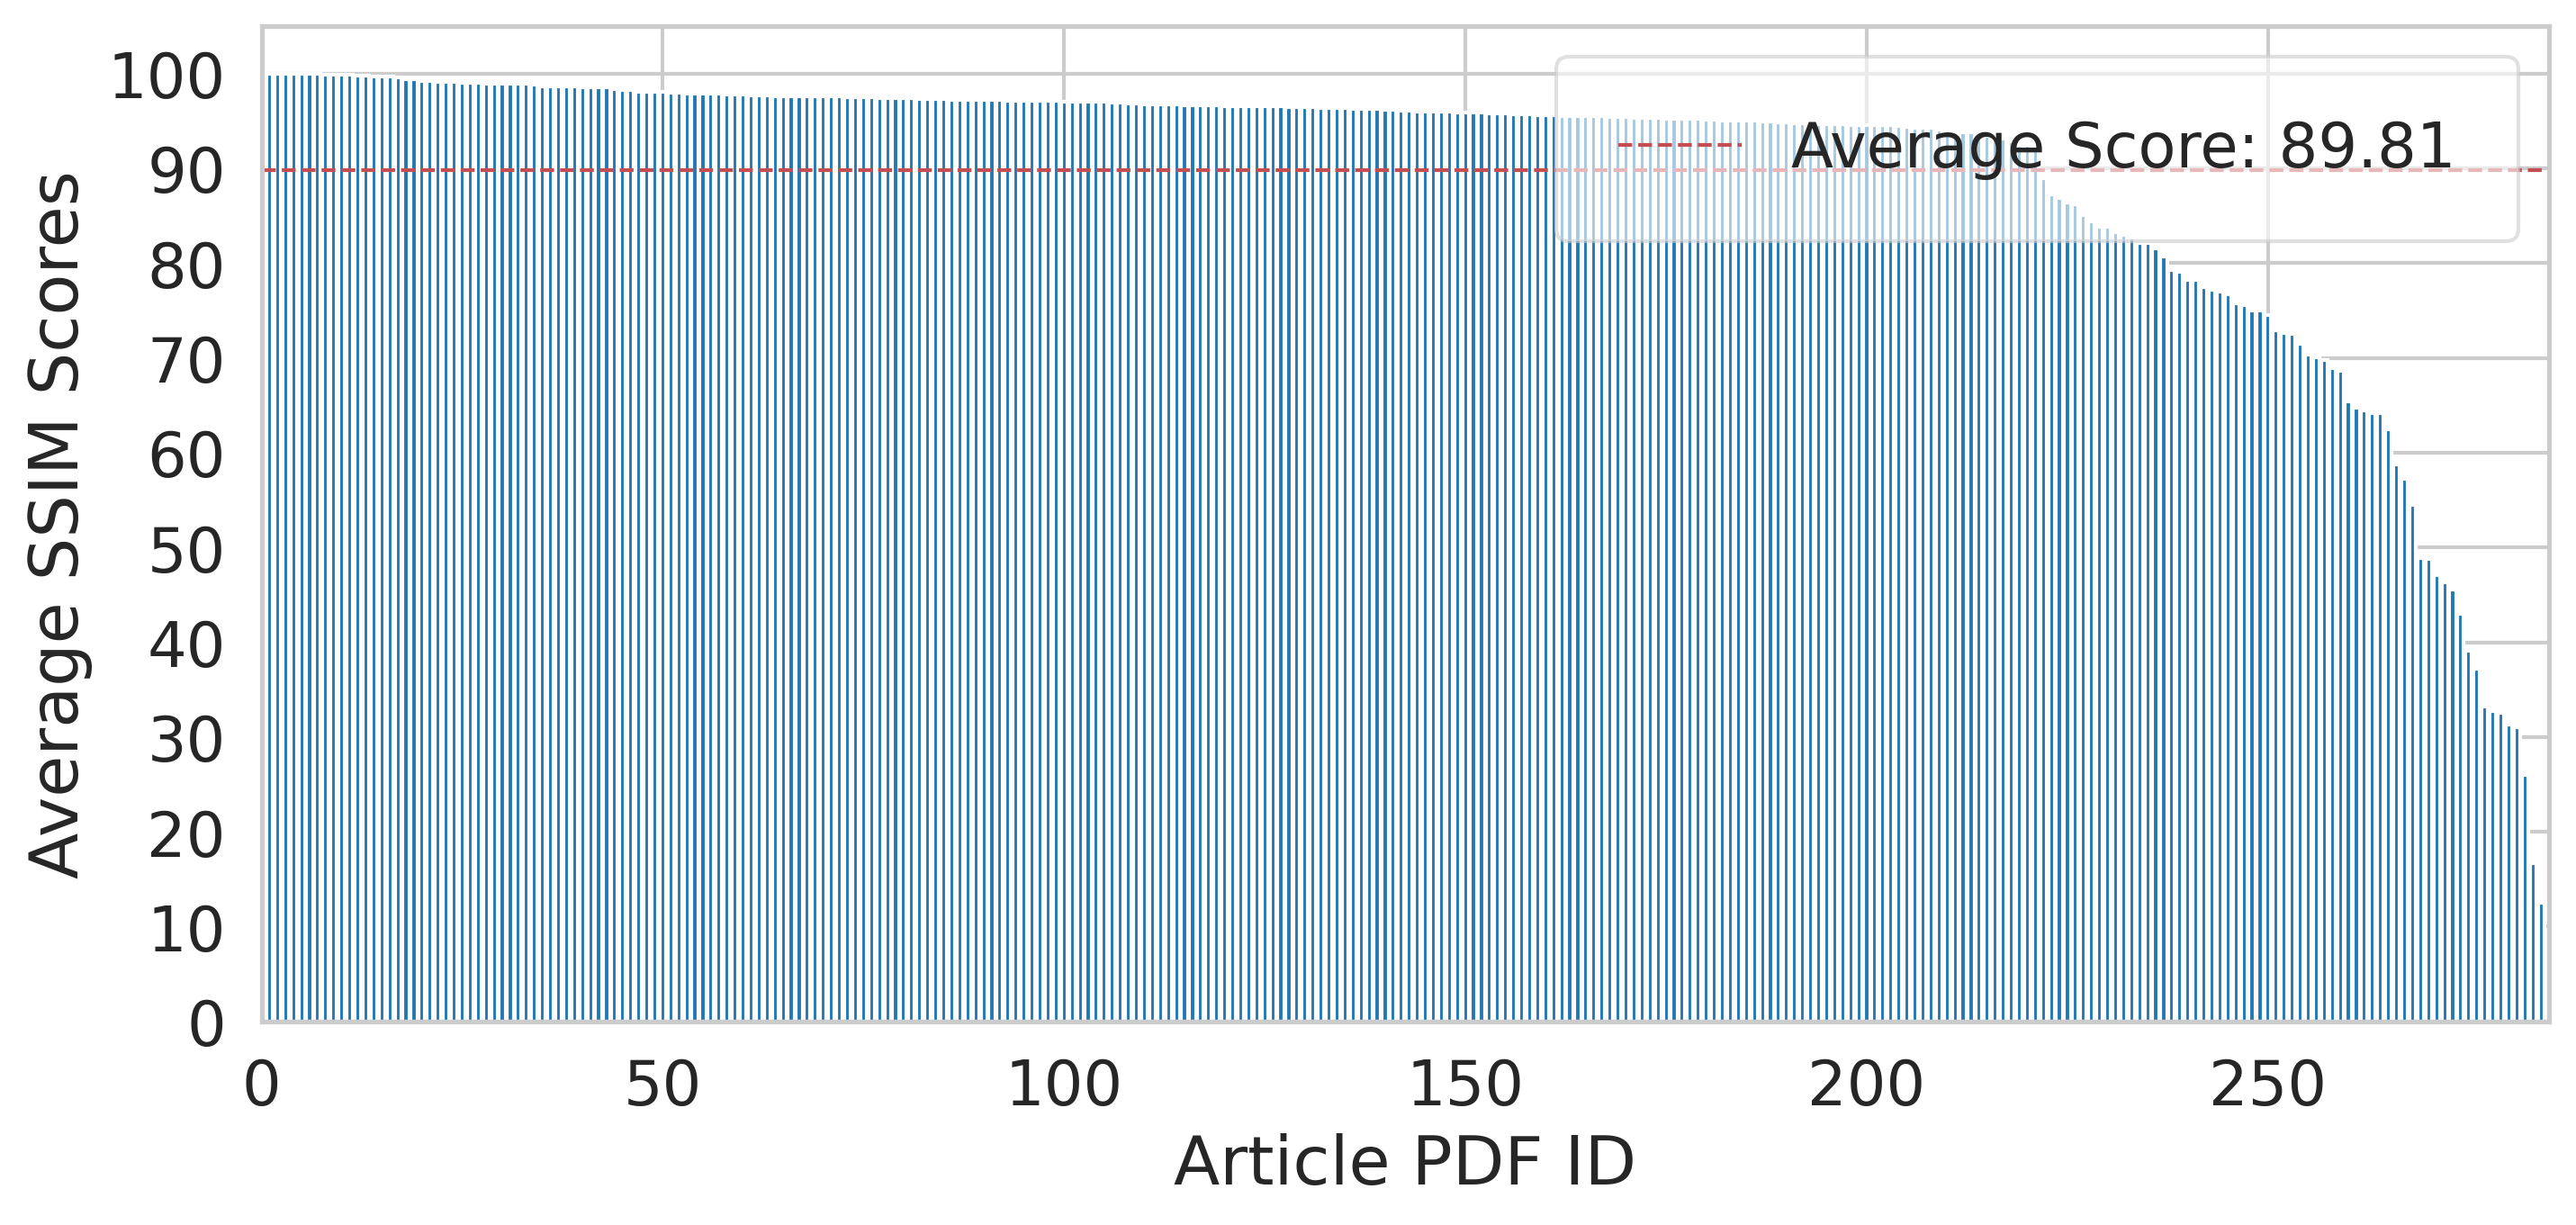

Score: 89.81 +/- 16.04


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
# increase font size
plt.rcParams.update({'font.size': 22})

means = [pdf_scores[pdf]['mean_ssim'] for pdf in pdf_scores.keys()]
means = sorted(means,reverse=True)
y = np.array(means)
x = np.arange(len(means))

plt.figure(figsize=(10,5),dpi=300)
plt.axhline(y.mean(), color='r', linestyle='dashed', linewidth=1,label=f'Average Score: {y.mean():.2f}' )
plt.bar(x, means, color=mcolors.TABLEAU_COLORS['tab:blue'])
plt.xlabel('Article PDF ID')
plt.ylabel("Average SSIM Scores")
# make graph starts in zero
plt.xlim(0,len(x))
plt.yticks(np.arange(0, 110, 10))
# make graph readable
plt.legend(fancybox=True, framealpha=0.6, borderpad=1)
plt.tight_layout()
plt.savefig('ssim_scores.pdf')
plt.show()

print(f"Score: {y.mean():.2f} +/- {y.std():.2f}")

In [11]:
# total number of extracted images
total_extracted = len(glob("/data/jcardenuto/projects/thesis-images/sciint/xfigs/**/*", recursive=True))
print(f"Total Extracted image elements: {total_extracted}")
# total number of matched images
total_matched = 0
for pdf in pdf_scores.keys():
    for fig in pdf_scores[pdf].keys():
        if fig.startswith('fig'):
            if pdf_scores[pdf][fig]['match'] != '':
                total_matched += 1
print(f"Matched Figures: {total_matched}")
# total number of orig images
total_orig = len(glob("/data/jcardenuto/projects/thesis-images/sciint/pdf-content-extraction-data/figures/**/*", recursive=True))
print(f"Number of Original Figures: {total_orig}")

# percentage of matched images
print(f"Percentage of Matched Images: {total_matched/total_orig*100:.2f}%")

Total Extracted image elements: 3994
Matched Figures: 1742
Number of Original Figures: 2161
Percentage of Matched Images: 80.61%


## Evaluating number of hits

## Image Recall 

In [12]:
# Total number of images
nfigs = 0
for key in pdf_scores.keys():
    for fig in pdf_scores[key]:
        if type(pdf_scores[key][fig]) == dict:
            nfigs += 1
print( f'Total number of figures: {nfigs}')

Total number of figures: 1876


In [13]:
# Hits curve with different thresholds
hits = []
for chosen_score in np.linspace(0,1,num=100):
    hit = 0
    for key in pdf_scores.keys():
        for fig in pdf_scores[key]:
            if type(pdf_scores[key][fig]) == dict:
                score = float(pdf_scores[key][fig]['score'])
                if score > chosen_score:
                    hit+=1
    hits.append(hit)

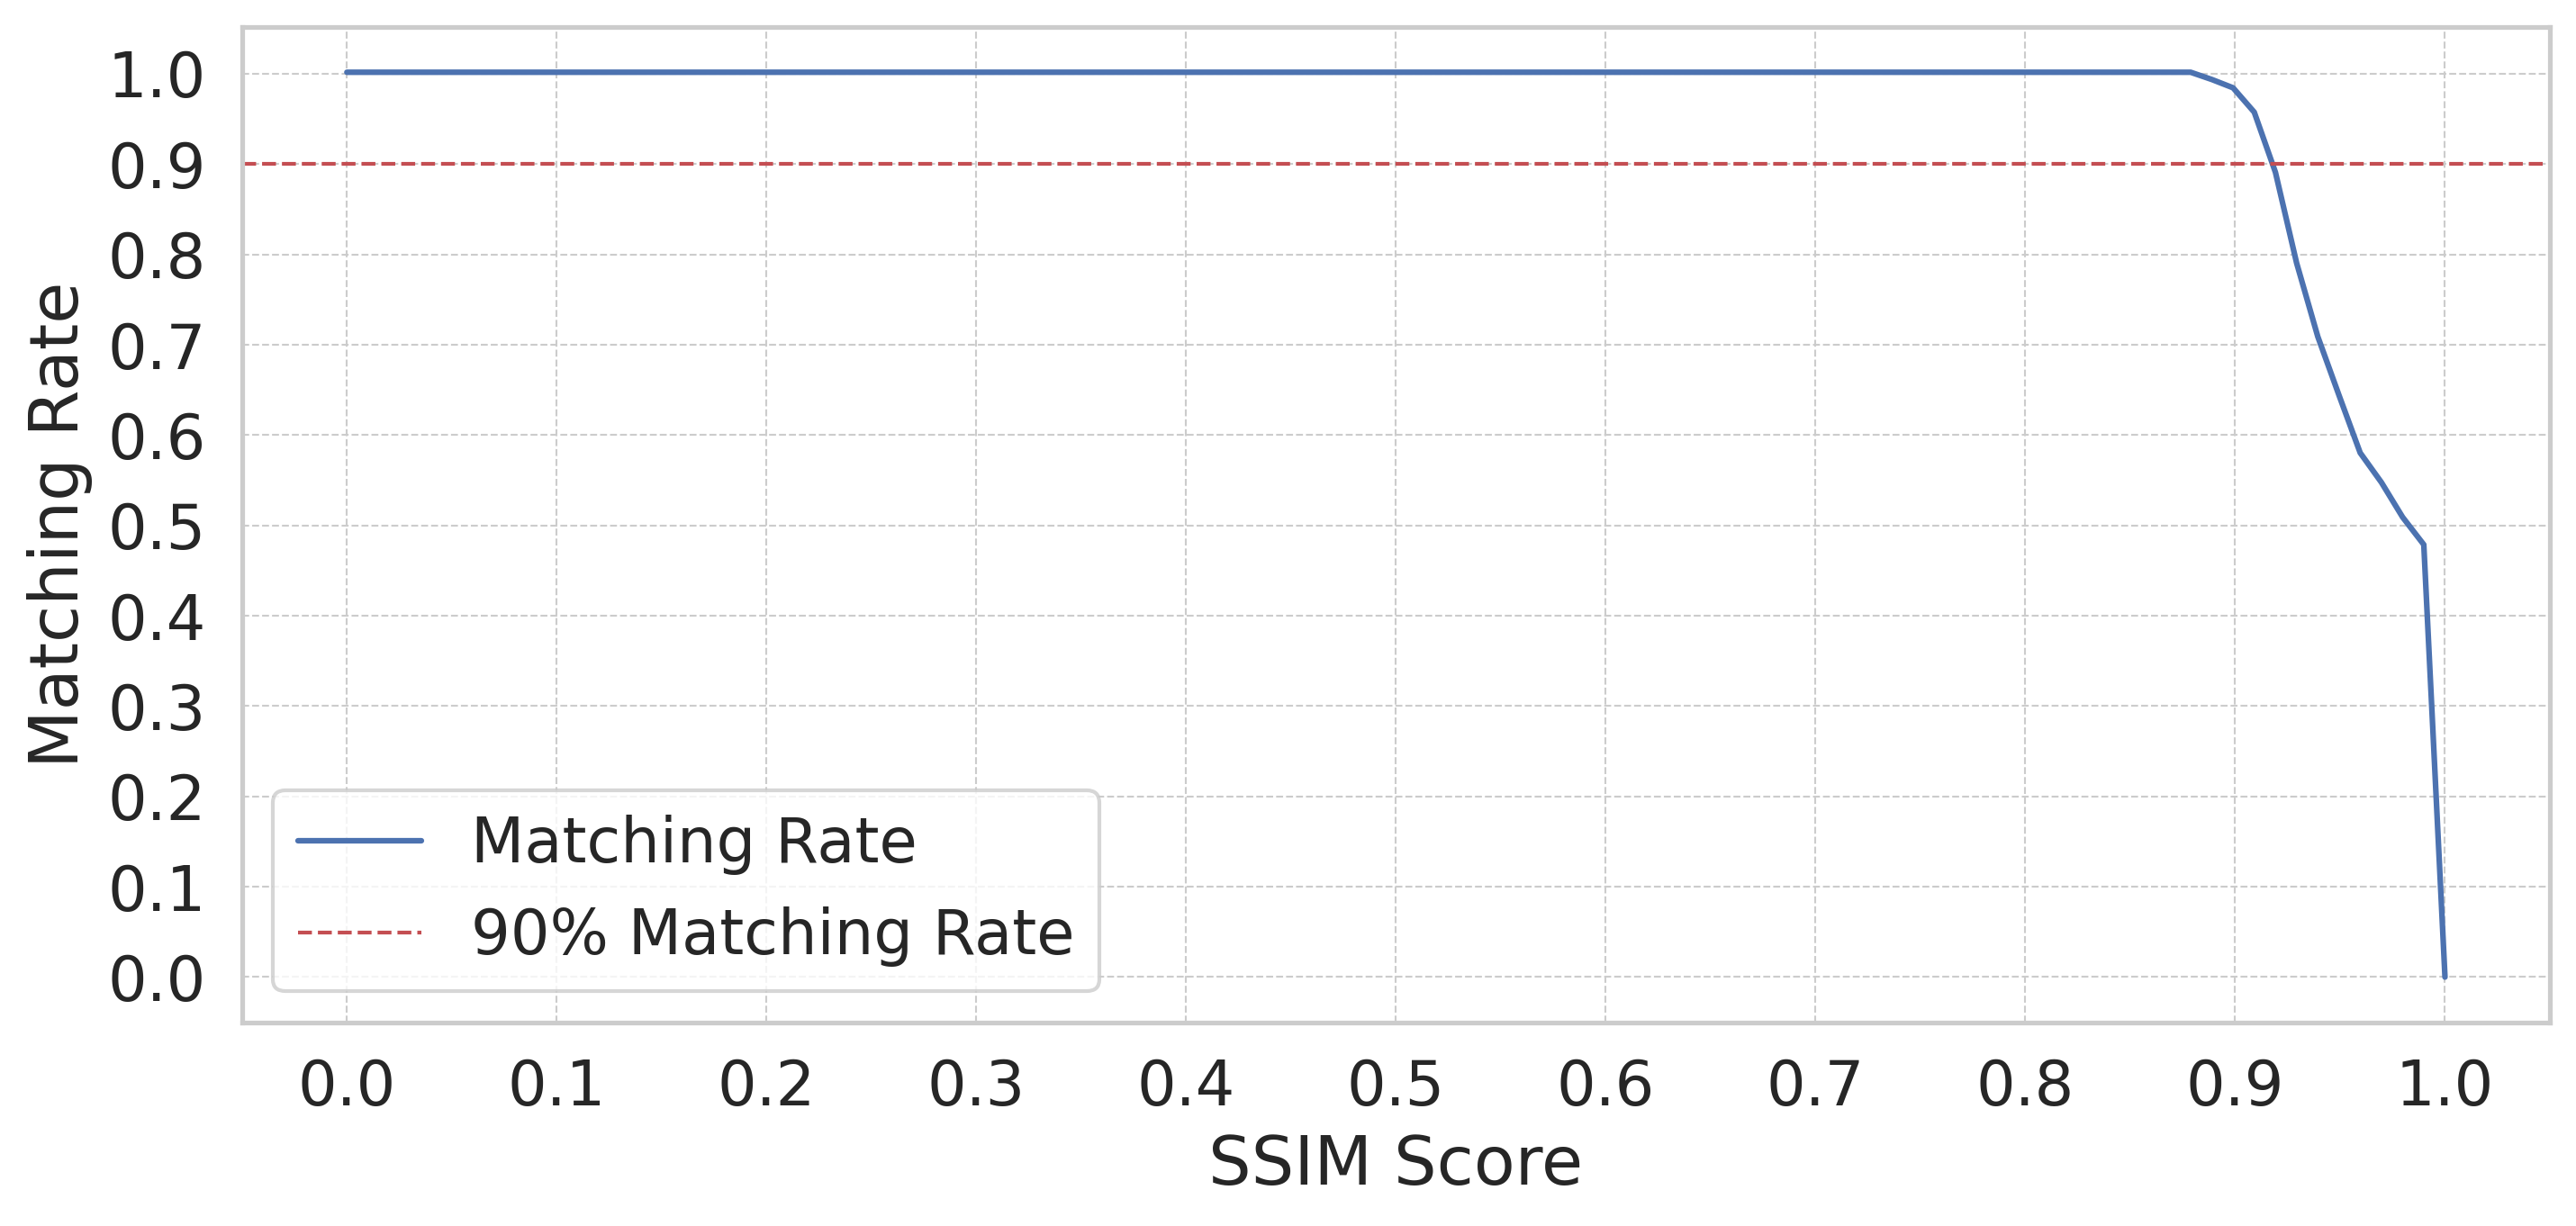

In [34]:
# Plotting the hits curve
plt.figure(figsize=(10,5), dpi=300)
sns.set_theme(style="whitegrid", font_scale=1.5)
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(0,1,num=100), np.array(hits)/1742)
# plot line in success rate = 0.7
plt.axhline(0.9, color='r', linestyle='--', linewidth=1)
# make grid visible on 0.7
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,1.1,0.1))
plt.legend(['Matching Rate','90% Matching Rate'])
plt.xlabel('SSIM Score')
plt.ylabel('Matching Rate')
plt.tight_layout()
plt.savefig('ssim_curve.pdf')
plt.show()

In [15]:
hit = 0
for key in pdf_scores.keys():
    for fig in pdf_scores[key]:
        if type(pdf_scores[key][fig]) == dict:
            score = float(pdf_scores[key][fig]['score'])
            if score > 0.9:
                hit+=1

In [16]:
result = hit / nfigs 
print(f"Image Recall (SSIM >=0.9) = {result:.02f}")

Image Recall (SSIM >=0.9) = 0.91
